In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf



2024-02-03 01:09:33.457599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 01:09:34.050310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set GPU Growth


In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)



2024-02-03 01:02:26.628602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-03 01:02:26.628634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: hitaish-OMEN-Laptop-15-en1xxx
2024-02-03 01:02:26.628643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: hitaish-OMEN-Laptop-15-en1xxx
2024-02-03 01:02:26.628816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.154.5
2024-02-03 01:02:26.628845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.154.5
2024-02-03 01:02:26.628852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.154.5


# Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')



In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positives and Anchors

## Untar Labelled Faces in the Wild Dataset

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor Classes


In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/54956764-c1d4-11ee-917e-950fba170308.jpg'

In [30]:
# Establish a connection to the   webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

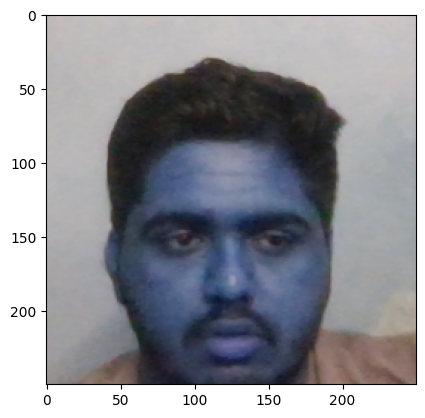

In [39]:
plt.imshow(frame[:])

# Load and PreProcess images

In [43]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)


In [44]:
dir_test = anchor.as_numpy_iterator()

2024-02-02 20:15:54.167795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [313]
	 [[{{node Placeholder/_0}}]]
2024-02-02 20:15:54.168075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [313]
	 [[{{node Placeholder/_0}}]]


In [45]:
print(dir_test.next())

b'data/anchor/73d71699-c1d5-11ee-917e-950fba170308.jpg'


## Preprocessing - Scale and Resize


In [4]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [48]:
img = preprocess('data/anchor/73d71699-c1d5-11ee-917e-950fba170308.jpg')

In [49]:
img.numpy().max() 

0.78357846

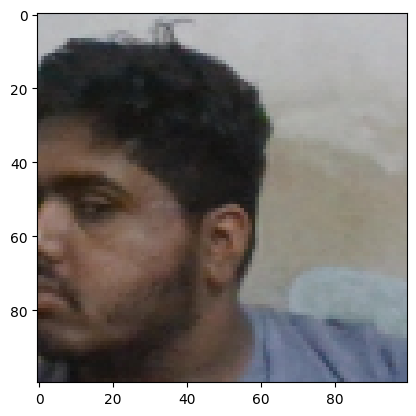

In [50]:
plt.imshow(img)

## Creating Labelled DataSet


In [52]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [53]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [54]:
samples = data.as_numpy_iterator()

2024-02-02 20:19:09.615641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [300]
	 [[{{node Placeholder/_39}}]]
2024-02-02 20:19:09.615981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype float and shape [300]
	 [[{{node Placeholder/_18}}]]


In [55]:
exampple = samples.next()

In [56]:
exampple

(b'data/anchor/937892b6-c1d5-11ee-917e-950fba170308.jpg',
 b'data/positive/ccafe27b-c1d7-11ee-917e-950fba170308.jpg',
 1.0)

## Build Train Test Partition

In [57]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [58]:
res = preprocess_twin(*exampple)

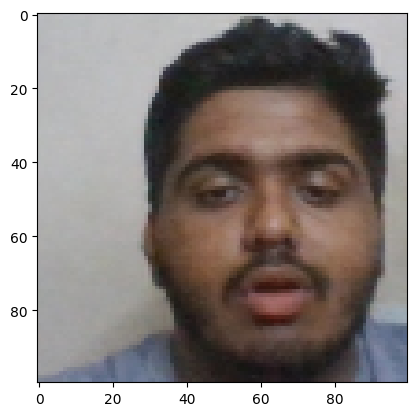

In [59]:
plt.imshow(res[1])

In [60]:
res[2]

1.0

In [61]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [62]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [63]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## Build Embedding Layer

In [64]:
inp = Input(shape=(100,100,3), name='input_image')

In [65]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [66]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [67]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [68]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [69]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [70]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [71]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [72]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [73]:
embedding = make_embedding()

In [74]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

# Build Distace Layer 

In [5]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [6]:
l1 = L1Dist()

In [77]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

# Making Siamese Model

In [78]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [79]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [80]:
siamese_layer = L1Dist()

In [81]:
distances = siamese_layer(inp_embedding, val_embedding)

In [82]:
classifier = Dense(1, activation='sigmoid')(distances)

In [83]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [84]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [85]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [86]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [87]:
siamese_model = make_siamese_model()

In [88]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training the Model 

## Set up Loss and optimizers

In [89]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [90]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [91]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Build Train Step Function

In [92]:
test_batch = train_data.as_numpy_iterator()

2024-02-02 20:30:45.731816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype string and shape [13233]
	 [[{{node Placeholder/_30}}]]
2024-02-02 20:30:45.732220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype float and shape [300]
	 [[{{node Placeholder/_18}}]]


In [93]:
batch_1 = test_batch.next()

In [94]:
X = batch_1[:2]

In [95]:
y = batch_1[2]

In [96]:
y

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [98]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss


### Build Training Loop

In [99]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [100]:
EPOCHS = 50

In [101]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 290s 11s/step

 Epoch 2/50
27/27 [==============================] - 288s 11s/step

 Epoch 3/50
27/27 [==============================] - 288s 11s/step

 Epoch 4/50
27/27 [==============================] - 286s 11s/step

 Epoch 5/50
27/27 [==============================] - 280s 10s/step

 Epoch 6/50
27/27 [==============================] - 280s 10s/step

 Epoch 7/50
27/27 [==============================] - 281s 10s/step

 Epoch 8/50
27/27 [==============================] - 282s 10s/step

 Epoch 9/50
27/27 [==============================] - 280s 10s/step

 Epoch 10/50
27/27 [==============================] - 282s 10s/step

 Epoch 11/50
27/27 [==============================] - 283s 10s/step

 Epoch 12/50
27/27 [==============================] - 284s 11s/step

 Epoch 13/50
27/27 [======

# Evaluate Model


In [102]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [103]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


2024-02-03 00:43:34.694033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [313]
	 [[{{node Placeholder/_21}}]]
2024-02-03 00:43:34.694892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [313]
	 [[{{node Placeholder/_21}}]]


In [104]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[4.4618534e-07],
       [3.3815493e-08],
       [7.9340744e-08],
       [1.3264410e-07],
       [9.9998963e-01],
       [2.2711791e-07],
       [1.9355927e-08],
       [1.0000000e+00],
       [9.9999040e-01],
       [1.0000000e+00],
       [9.9999988e-01],
       [9.2991662e-08],
       [4.9114851e-07],
       [4.4184226e-06],
       [9.5469829e-08],
       [3.0573752e-09]], dtype=float32)

In [105]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [106]:
y_true

array([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Calculate Metrics

In [107]:


# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()



1.0

In [108]:


# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()



1.0

#### Visualize Results

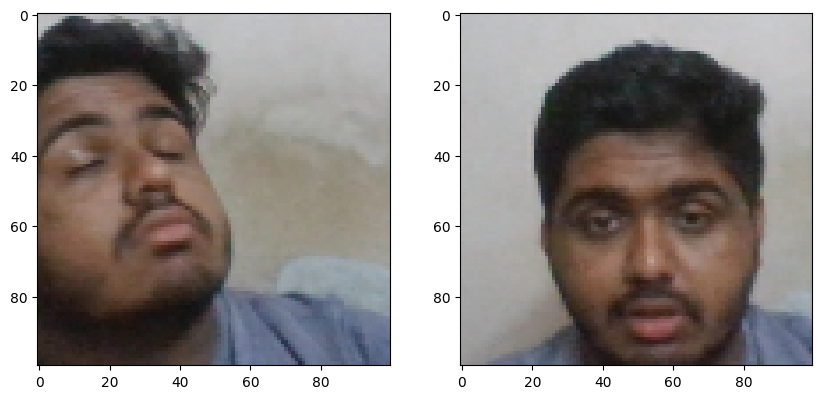

In [113]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

# Save Model

In [114]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [7]:
L1Dist

__main__.L1Dist

In [8]:
import tensorflow as tf
import numpy as np  
import os
import cv2
import random
from matplotlib import pyplot as plt
import uuid

# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

2024-02-03 01:10:16.706494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-03 01:10:16.706522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: hitaish-OMEN-Laptop-15-en1xxx
2024-02-03 01:10:16.706530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: hitaish-OMEN-Laptop-15-en1xxx
2024-02-03 01:10:16.706664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.154.5
2024-02-03 01:10:16.706689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.154.5
2024-02-03 01:10:16.706695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.154.5


In [11]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

In [9]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time  Test

In [10]:
os.listdir(os.path.join('application_data', 'verification_images'))

['198203d0-c1d6-11ee-917e-950fba170308.jpg',
 'cf154a8d-c1d7-11ee-917e-950fba170308.jpg',
 '6f2faba0-c1d6-11ee-917e-950fba170308.jpg',
 '20f4cd09-c1d6-11ee-917e-950fba170308.jpg',
 'cf154a8b-c1d7-11ee-917e-950fba170308.jpg',
 '1f04df74-c1d6-11ee-917e-950fba170308.jpg',
 '7a2bcd36-c1d6-11ee-917e-950fba170308.jpg',
 '0d67e78e-c1d6-11ee-917e-950fba170308.jpg',
 '1c080804-c1d7-11ee-917e-950fba170308.jpg',
 '9ffe086c-c1d6-11ee-917e-950fba170308.jpg',
 '63b44ff6-c1d6-11ee-917e-950fba170308.jpg',
 '9e69ce1f-c1d6-11ee-917e-950fba170308.jpg',
 '6f2faba2-c1d6-11ee-917e-950fba170308.jpg',
 'cd572690-c1d6-11ee-917e-950fba170308.jpg',
 '5c7f2792-c1d6-11ee-917e-950fba170308.jpg',
 '0f102f74-c1d6-11ee-917e-950fba170308.jpg',
 'cde251d5-c1d7-11ee-917e-950fba170308.jpg',
 'cde251ce-c1d7-11ee-917e-950fba170308.jpg',
 'c370f0f0-c1d7-11ee-917e-950fba170308.jpg',
 '8e0edece-c1d6-11ee-917e-950fba170308.jpg',
 'cde251d0-c1d7-11ee-917e-950fba170308.jpg',
 '2b4ce5a6-c1d6-11ee-917e-950fba170308.jpg',
 '2dbc8d64

In [11]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [12]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/198203d0-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/cf154a8d-c1d7-11ee-917e-950fba170308.jpg
application_data/verification_images/6f2faba0-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/20f4cd09-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/cf154a8b-c1d7-11ee-917e-950fba170308.jpg
application_data/verification_images/1f04df74-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/7a2bcd36-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/0d67e78e-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/1c080804-c1d7-11ee-917e-950fba170308.jpg
application_data/verification_images/9ffe086c-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/63b44ff6-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/9e69ce1f-c1d6-11ee-917e-950fba170308.jpg
application_data/verification_images/6f2faba2-c1d6-11ee-917e-950

In [15]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# Open CV Real Time Verification

In [17]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    try:
        ret, frame = cap.read()
        frame = frame[120:120+250,200:200+250, :]
        
        cv2.imshow('Verification', frame)
        
        # Verification trigger
        if cv2.waitKey(10) & 0xFF == ord('v'):
            # Create directories if they don't exist
            os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)
            
            # Save input image to application_data/input_image folder 
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            
            # Run verification
            results, verified = verify(model, 0.9, 0.7)
            print(verified)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    except Exception as e:
        print("An error occurred:", str(e))
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 102ms/step
False
1/1 [==============================] - 0s 97ms/step
True
1/1 [==============================] - 0s 98ms/step
True
1/1 [==============================] - 0s 97ms/step
True
1/1 [==============================] - 0s 97ms/step
True
1/1 [==============================] - 0s 97ms/step
True
1/1 [==============================] - 0s 102ms/step
True
1/1 [==============================] - 0s 98ms/step
True
1/1 [==============================] - 0s 97ms/step
True
1/1 [==============================] - 0s 99ms/step
False
1/1 [==============================] - 0s 106ms/step
True
1/1 [==============================] - 0s 98ms/step
False
1/1 [==============================] - 0s 99ms/step
False
1/1 [==============================] - 0s 96ms/step
False
1/1 [==============================] - 0s 100ms/step
False
1/1 [==============================] - 0s 97ms/step
False
1/1 [==============================] - 0s 99ms/step
True
1/1 [===============

In [13]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: /home/hitaish/Documents/facerecognition/build_siamies_network
